In [1]:
from firedrake import *
import matplotlib.pyplot as plt
from scipy import signal
import numpy as np
%matplotlib inline

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
# Define mesh
mesh = RectangleMesh(50, 50, 10, 10, quadrilateral=True)

In [3]:
#help(RectangleMesh)

In [4]:
fe = VectorElement("CG", quadrilateral, 2, variant="spectral")
V = FunctionSpace(mesh, fe)

In [5]:
bc = [] # DirichletBC(V, Constant([0, 0]), 1)

def gau(t):
    fc = 10
    ampu = 1e5
    gau_val = ampu*signal.gausspulse(t, fc)
    return gau_val

def RickerWavelet(t, freq, amp=1.0):
    # Shift in time so the entire wavelet is injected
    t = t - (np.sqrt(6.0) / (np.pi * freq))
    return amp * (
        1.0 - (1.0 / 2.0) * (2.0 * np.pi * freq) * (2.0 * np.pi * freq) * t * t
    )

def delta_expr(x0, x, y, sigma_x=2000.0):
    sigma_x = Constant(sigma_x)
    return exp(-sigma_x * ((x - x0[0]) ** 2 + (y - x0[1]) ** 2))

x, y = SpatialCoordinate(mesh)
source = Constant([5, 5])
freq = 10

t = 0.0
gaus = Constant(0.0)
gaus.assign(gau(t))

ricker = Constant(0.0)
ricker.assign(RickerWavelet(t, freq))

Constant(FiniteElement('Real', None, 0), 3)

In [6]:
rho = Constant(2e3)
g = Constant(1)
#f = as_vector([0, ricker])
f = as_matrix([[ricker, 0], [0, ricker]])
E  = 1e5
nu = 0.3
mu    = (E / (2.0*(1.0 + nu)))
lambda_ = (E*nu / ((1.0 + nu)*(1.0 - 2.0*nu)))
M = lambda_ + 2*mu
Id = Identity(mesh.geometric_dimension()) # 2x2 Identity tensor
M

134615.38461538462

In [7]:
def epsilon(u):
    return 0.5*(grad(u) + grad(u).T)

def sigma(u):
    return lambda_*div(u)*Id + 2*mu*epsilon(u)

In [8]:
u = TrialFunction(V)
v = TestFunction(V)
u0, v0, a0 = Function(V), Function(V), Function(V)

# Time stepping parameters
beta, gamma = 0.25, 0.5
T = 0.8
nsteps = 80
dt = T/nsteps
t = 0.0
time = np.linspace(0., T, nsteps+1)

In [9]:
v1 = (gamma/(beta*dt))*(u - u0) - (gamma/beta - 1.0)*v0 - dt*(gamma/(2.0*beta) - 1.0)*a0
a1 = (1.0/(beta*dt**2))*(u - u0 - dt*v0) - (1.0/(2.0*beta) -1.0)*a0

In [10]:
def update(u, u0, v0, a0, beta, gamma, dt):
    # Get vectors (references)
    u_vec, u0_vec = u.vector().array(), u0.vector().array()
    v0_vec, a0_vec = v0.vector().array(), a0.vector().array()
    # Update acceleration and velocity
    a_vec = (1.0/(2.0*beta))*( (u_vec - u0_vec -
    v0_vec*dt)/(0.5*dt*dt) - (1.0-2.0*beta)*a0_vec )
    # v = dt * ((1-gamma)*a0 + gamma*a) + v0
    v_vec = dt*((1.0-gamma)*a0_vec + gamma*a_vec) + v0_vec
    # Update (t(n) <-- t(n+1))
    v0.vector().array()[:], a0.vector().array()[:] = v_vec, a_vec
    u0.vector().array()[:] = u.vector().array()

In [11]:
# Residual
res = rho*inner(a1, v)*dx + inner(sigma(u), sym(grad(v)))*dx + delta_expr(source, x, y)*inner(f, sym(grad(v)))*dx
    #+ dot(f, v)*ds(2)

a_form = lhs(res)
L_form = rhs(res)

file = File("ex3/displacement.pvd")

In [12]:
for (i, dt) in enumerate(np.diff(time)):
    t = time[i+1]
    print("Time: ", t)
    #gaus.assign(gau(t))
    ricker.assign(RickerWavelet(t, freq))
    u = Function(V, name='displacemnt')
    solve(a_form == L_form, u, bcs=bc, solver_parameters={"ksp_monitor": None})

    update(u, u0, v0, a0, beta, gamma, dt)

    file.write(u, time=t)

Time:  0.01
    Residual norms for firedrake_0_ solve.
    0 KSP Residual norm 2.660829849233e+03 
    1 KSP Residual norm 7.170766006108e-13 
Time:  0.02
    Residual norms for firedrake_1_ solve.
    0 KSP Residual norm 2.660829849233e+03 
    1 KSP Residual norm 7.170766006108e-13 
Time:  0.03
    Residual norms for firedrake_2_ solve.
    0 KSP Residual norm 2.660829849233e+03 
    1 KSP Residual norm 7.170766006108e-13 
Time:  0.04
    Residual norms for firedrake_3_ solve.
    0 KSP Residual norm 2.660829849233e+03 
    1 KSP Residual norm 7.170766006108e-13 
Time:  0.05
    Residual norms for firedrake_4_ solve.
    0 KSP Residual norm 2.660829849233e+03 
    1 KSP Residual norm 7.170766006108e-13 
Time:  0.06
    Residual norms for firedrake_5_ solve.
    0 KSP Residual norm 2.660829849233e+03 
    1 KSP Residual norm 7.170766006108e-13 
Time:  0.07
    Residual norms for firedrake_6_ solve.
    0 KSP Residual norm 2.660829849233e+03 
    1 KSP Residual norm 7.170766006108e-13 

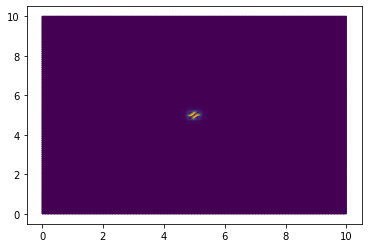

In [13]:
tripcolor(u)